# Set up 


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize
import threading
from scipy.optimize import LinearConstraint
from datetime import datetime

In [2]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

# df_err.reindex(np.arange(1,df_err.shape[0]))
# df_crt.reindex(np.arange(1,df_crt.shape[0]))

In [3]:
df

,Oldnew,Setsize,Probtype,Lag,Error,FileCondi,RT
,,,,,,,mean
0,new,2,AN,0,0,ANpure,808.779720
1,new,2,AN,0,0,CMat,692.045652
2,new,2,AN,0,0,MIX,749.161058
3,new,2,AN,0,0,MIX2,903.858079
4,new,2,AN,0,1,ANpure,801.656250
...,...,...,...,...,...,...,...
298,old,8,VM,6,1,VMpure,972.575000
299,old,8,VM,7,0,VMpure,964.521739
300,old,8,VM,7,1,VMpure,868.483871


## Some global setting

In [13]:
global vary_ss, give_c2
vary_ss=0
give_c2=0
    
global Which_file
Which_file = "MIX"

# Parameter set

In [5]:
global boost, alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2
  
alpha={}; beta ={}; s = {}; F = {}; L = {}


boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

s["all"]=0.01
s["ss24"]=0.01
s["ss8"]=0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c = 0.3938
c2=0.3
Old_crit = 1.9197
New_crit = -2.33
t0 = 699.98
kao = 37

#---CM
F["CM_oldiold_oldinew"] = 0.2

L["CM_oldiold_newinew"] = 0.2
L["CM_oldinew_newiold"] = 0.2

#---AN
F["AN_oldiold_oldinew"] = 0.2

# Assign LTM global

In [6]:
def assign_LTM_global(item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    
    if item_condi=="CM":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["CM_oldiold_oldinew"]
        else: Fnow = 0
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":
            
            Lnow = L["CM_oldiold_newinew"]
        elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":
            
            Lnow = L["CM_oldinew_newiold"]
        else: Lnow=0
            
    if item_condi == "AN":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["AN_oldiold_oldinew"]
        else: Fnow=0
        
        Lnow = 0
    
    return(Fnow + Lnow)

assign_LTM_global("AN","old","old")
        

0.2

# Calc A (activation)

In [7]:
# seperate albes
def calcA(df, name):

    
    dnow = df[df['FileCondi']==name]
    a = np.zeros((dnow.shape[0], 8))  #activation
    

    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    for j in range(1,9):

        indexj = j-1
        
        
        if vary_ss==0:
            
            a[dnow["Lag"]==j,indexj] = m[indexj]
            a[dnow["Lag"]!=j,indexj] = m[indexj] * s["all"]
        else:
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]!=8),indexj] = m[indexj] * s["ss24"]
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==8),indexj] = m[indexj] * s["ss8"]
            a[dnow["Lag"]==j,indexj] = m[indexj]
        
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
                  "\n snow", snow,\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

print(calcA(df[df["Error"]==0], "CMat"))


[0.01815275 0.01815275 0.0265232  0.0265232  0.03853018 0.03853018
 1.19625275 0.63717528 1.19625275 0.63717528 1.2046232  0.64554573
 0.47952792 0.40219313 1.2046232  0.64554573 0.47952792 0.40219313
 1.21663018 0.65755271 0.4915349  0.41420011 0.37013656 0.34193666
 0.32246373 0.30827473 1.21663018 0.65755271 0.4915349  0.41420011
 0.37013656 0.34193666 0.32246373 0.30827473]


# Calc p (drift rate)

In [8]:
# F["AN_oldiold_oldinew"] = 0.099
def calcp(df, name):
    
    A = calcA(df, name)
    dnow = df[df['FileCondi']==name]
    p = np.repeat(3.0, A.shape[0])
    
    probs = dnow["Probtype"].astype("category").cat.categories.to_numpy() #get categories name
    

    for iprob in probs:
        
        for ion in ["old","new"]:
            
            tf_ion = dnow['Oldnew'] == ion
            tf_iprob = dnow['Probtype'] == iprob
            tf_all = np.logical_and(tf_ion, tf_iprob)
            
#             print(iprob)
            IR_old_current = assign_LTM_global(iprob,"old",ion)
            IR_new_current = assign_LTM_global(iprob,"new",ion)
        
            if give_c2==0:
                p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c + IR_new_current)
            elif give_c2==1: 
                if iprob=="CM":
                    p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c + c2 + IR_new_current)
                else:
                    p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c + IR_new_current)
                
            
#         break
        

    return(np.array(p))



ok1=calcp(df, "ANpure")
on = df[df['FileCondi']=="ANpure"]["Oldnew"]
onn = df[df['FileCondi']=="ANpure"]["Probtype"]
ss = df[df['FileCondi']=="ANpure"]["Setsize"]
lagg = df[df['FileCondi']=="ANpure"]["Lag"]
# print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) for i in range(ok1.shape[0])]))
print(np.array([str(ok1[i].round(8))+"-"+str(on.iloc[i]) +"-"+str(onn.iloc[i])+"-ss:"+str(ss.iloc[i])\
                + "-lag:" + str(lagg.iloc[i]) for i in range(ok1.shape[0])]))


['0.35648627-new-AN-ss:2-lag:0' '0.35648627-new-AN-ss:2-lag:0'
 '0.36516964-new-AN-ss:4-lag:0' '0.36516964-new-AN-ss:4-lag:0'
 '0.3772241-new-AN-ss:8-lag:0' '0.3772241-new-AN-ss:8-lag:0'
 '0.78000648-old-AN-ss:2-lag:1' '0.78000648-old-AN-ss:2-lag:1'
 '0.68009106-old-AN-ss:2-lag:2' '0.68009106-old-AN-ss:2-lag:2'
 '0.78103041-old-AN-ss:4-lag:1' '0.78103041-old-AN-ss:4-lag:1'
 '0.6822517-old-AN-ss:4-lag:2' '0.6822517-old-AN-ss:4-lag:2'
 '0.63310374-old-AN-ss:4-lag:3' '0.63310374-old-AN-ss:4-lag:3'
 '0.60461575-old-AN-ss:4-lag:4' '0.60461575-old-AN-ss:4-lag:4'
 '0.78248264-old-AN-ss:8-lag:1' '0.78248264-old-AN-ss:8-lag:1'
 '0.68530056-old-AN-ss:8-lag:2' '0.68530056-old-AN-ss:8-lag:2'
 '0.63716269-old-AN-ss:8-lag:3' '0.63716269-old-AN-ss:8-lag:3'
 '0.60932544-old-AN-ss:8-lag:4' '0.60932544-old-AN-ss:8-lag:4'
 '0.59146689-old-AN-ss:8-lag:5' '0.59146689-old-AN-ss:8-lag:5'
 '0.5791551-old-AN-ss:8-lag:6' '0.5791551-old-AN-ss:8-lag:6'
 '0.57021108-old-AN-ss:8-lag:7' '0.57021108-old-AN-ss:8-lag:7

# RW 

In [15]:

def calc_theoretical_RW(df, name):

    A = calcA(df, name)
    p = calcp(df, name)

#     dnow
    dnow = df[df['FileCondi']==name]

    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)

    q = 1-p

    AA = Old_crit
    BB = -New_crit # bb is a postive number

    exp_nstep = np.zeros(p.shape[0])

    
    theta1 = ((p/q)**(AA+BB)+1)/((p/q)**(AA+BB)-1)
    theta2 = ((p/q)**BB+1)/((p/q)**BB-1)

    
    tf = np.logical_and(p!=q , dnow["Oldnew"]=='old')
    exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)
    
    tf = np.logical_and(p==q , dnow["Oldnew"]=='old')
    exp_nstep[tf] = (AA/3)*(2*BB+AA)
    
    #-------------------
    theta1 = ((p/q)**(-(AA+BB))+1)/((p/q)**(-(AA+BB))-1)
    theta2 = ((p/q)**-AA+1)/((p/q)**-AA-1)

    tf = np.logical_and(p!=q , dnow["Oldnew"]=='new')
    exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*AA)
    tf = np.logical_and(p==q , dnow["Oldnew"]=='new')
    exp_nstep[tf] = (BB/3)*(2*AA+BB)
    
    
    p_resp_old[p!=q] = ((1-(q/p)**BB)/(1-(q/p)**(AA+BB)))[p!=q]
    p_resp_old[p==q] = BB/(AA+BB)
    
    pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
    pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]
    
    pred_rt = t0 + kao * exp_nstep
    


    return(np.array(pred_rt), np.array(pred_correct))
          

df_sub_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()


ok1=calcp(df_sub_err, "MIX")
on = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Oldnew"]
onn = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Probtype"]
# print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) +"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])]))

jjj, ok1 =calc_theoretical_RW(df_sub_err, "MIX")
on = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Oldnew"]
onn = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Probtype"]
one = (df_sub_err[df_sub_err['FileCondi']=="MIX"][[("Error","mean")]]).to_numpy().round(3)

# print(np.array([str((ok1[i]).round(2))+"-"+str(on.iloc[i])+"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])]))

np.array([str(one[i])+"-"+str(on.iloc[i])+"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])])

array(['[0.028]-new-AN', '[0.039]-new-CM', '[0.039]-new-AN',
       '[0.103]-new-CM', '[0.056]-new-AN', '[0.191]-new-CM',
       '[0.042]-old-AN', '[0.051]-old-AN', '[0.059]-old-CM',
       '[0.043]-old-CM', '[0.026]-old-AN', '[0.049]-old-AN',
       '[0.079]-old-AN', '[0.091]-old-AN', '[0.035]-old-CM',
       '[0.11]-old-CM', '[0.133]-old-CM', '[0.125]-old-CM', '[0.]-old-AN',
       '[0.]-old-AN', '[0.095]-old-AN', '[0.172]-old-AN',
       '[0.159]-old-AN', '[0.14]-old-AN', '[0.164]-old-AN',
       '[0.065]-old-AN', '[0.015]-old-CM', '[0.061]-old-CM',
       '[0.09]-old-CM', '[0.069]-old-CM', '[0.083]-old-CM',
       '[0.074]-old-CM', '[0.159]-old-CM', '[0.246]-old-CM'], dtype='<U14')

# Calculate WSSE

In [16]:
w={}
w["new_rt"] = 4*2
w["old_rt"] = 1*2
w["new_err"] = 4
w["old_err"] = 1
# F["AN_oldiold_oldinew"] = 0.017
def calc_wssd(df, name):

    df_sub_org = df[df["FileCondi"] == name]
    df_sub_err = df_err[df_err["FileCondi"] == name]
    df_sub_crt = df_crt[df_crt["FileCondi"] == name]

    df_sub_err = df_sub_err.reset_index()
    df_sub_crt = df_sub_crt.reset_index()

    pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, name)
    pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, name)

    pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, name)
    pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, name)

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()

    return(WSSD)

# time1=time.time()
calc_wssd(df_org, "ANpure")
# print(time.time()-time1)
# df_sub_agg, WSSD = calc_wssd(df, "MIX")

0.8111491534532795

# Parameter search

## Asign parm_dic

In [17]:
if vary_ss==0:
     param_dic=np.array(( alpha["all"], beta["all"], s["all"],
                         c, Old_crit, New_crit, t0, kao,
                         F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                         F["AN_oldiold_oldinew"]))
else:
     param_dic=np.array((alpha["all"], beta["all"], s["ss24"], s["ss8"],
                         c, Old_crit, New_crit, t0, kao,
                         F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                         F["AN_oldiold_oldinew"]))
         
param_dic

array([ 1.9000e-01,  1.2000e+00,  1.0000e-02,  3.9380e-01,  1.9197e+00,
       -2.3300e+00,  6.9998e+02,  3.7000e+01,  2.0000e-01,  2.0000e-01,
        2.0000e-01,  2.0000e-01])

## optim_wsse

In [18]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    if vary_ss==0:
        [alpha["all"], beta["all"], s["all"],
                             c, Old_crit, New_crit, t0, kao,
                             F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                             F["AN_oldiold_oldinew"]] = params_dic
    else:
        [alpha["all"], beta["all"], s["ss24"], s["ss8"],
                             c, Old_crit, New_crit, t0, kao,
                             F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                         F["AN_oldiold_oldinew"]] = params_dic
    


    return calc_wssd(df_org, Which_file)
optim_wsse(param_dic)

2.6739953654714643

## random start

In [19]:
def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
    alpha={}; beta ={}; s = {}; F = {}; L = {}

    alpha["all"] = np.random.uniform(0.1,1)
    beta["all"] =np.random.uniform(1,2)
    s["all"] = np.random.uniform(0.01,1)
    s["ss24"] = np.random.uniform(0.01,1)
    s["ss8"] = np.random.uniform(0.01,1)
    c = np.random.uniform(0.05,0.99)
    c2=np.random.uniform(0.05,0.99)

    Old_crit = np.random.uniform(1,5)
    New_crit = np.random.uniform(-5,-1)
    t0 = 445.5
    kao = 50.4

    #---CM
    F["CM_oldiold_oldinew"] = np.random.uniform(0.01,1)

    L["CM_oldiold_newinew"] = np.random.uniform(0.01,1)
    L["CM_oldinew_newiold"] = np.random.uniform(0.001,1)

    #---AN
    F["AN_oldiold_oldinew"] = np.random.uniform(0.001,1)
    if vary_ss==0:
        param_dic=[alpha["all"], beta["all"], s["all"],
                             c, Old_crit, New_crit, t0, kao,
                             F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                             F["AN_oldiold_oldinew"]] 
    else:
        param_dic=[alpha["all"], beta["all"], s["ss24"], s["ss8"],
                             c, Old_crit, New_crit, t0, kao,
                             F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                         F["AN_oldiold_oldinew"]]

    return(param_dic)

if vary_ss==0:
    bdd = (

        (0.00001, 1.0), #alphaall
        (0.20, 6.0), #beta_all
        (0.001, 1.0), #s all

        (0.001, 0.99), #c

        (1, 10.0), #old_cr
        (-10.0, -1), #new_cr
        
        (400,700), #t0
        (10, 70), #kao
#         (638,638),#(400,700), #t0
#         (37,37),#(10, 70), #kao
#         (500,500),#(400,700), #t0
#         (22,22),#(10, 70), #kao

#         (0,0),#(0,0.99),#F["CM_oldiold_oldinew"],

#         (0,0),#(0,0.99),#L["CM_oldiold_newinew"],
#         (0,0),#(0,0.99),#L["CM_oldinew_newiold"],
        
        (0,0.99),#F["CM_oldiold_oldinew"],
        (0,0.99),#L["CM_oldiold_newinew"],
        (0,0.99),#L["CM_oldinew_newiold"],

        #---AN
        (0,0.9)#F["AN_oldiold_oldinew"]
          )
else:
    bdd = (

        (0.00001, 1.0), #alphaall
        (1, 3.0), #beta_all
        (0.001, 1.0), #s 24
        (0.001, 1.0), #s 8

        (0.001, 0.99), #c

        (1, 10.0), #old_cr
        (-10.0, -1), #new_cr
                
#         (400,700), #t0
#         (10, 70), #kao
        
#         (638,638),#(400,700), #t0
#         (37,37),#(10, 70), #kao
        (500,500),#(400,700), #t0
        (22,22),#(10, 70), #kao

        (0,0),#(0,0.99),#F["CM_oldiold_oldinew"],

        (0,0),#(0,0.99),#L["CM_oldiold_newinew"],
        (0,0),#(0,0.99),#L["CM_oldinew_newiold"],

        #---AN
        (0,0.20)#F["AN_oldiold_oldinew"]
          )
    
if give_c2==1:
    bdd = (

        (0.00001, 1.0), #alphaall
        (1, 6.0), #beta_all
        (0.001, 1.0), #s all

        (0.001, 0.99), #c
        (0.001, 0.99), #c2

        (1, 10.0), #old_cr
        (-10.0, -1), #new_cr
        
#         (400,700), #t0
#         (10, 70), #kao
#         (638,638),#(400,700), #t0
#         (37,37),#(10, 70), #kao
        (500,500),#(400,700), #t0
        (22,22),#(10, 70), #kao

        (0,0),#(0,0.99),#F["CM_oldiold_oldinew"],

        (0,0),#(0,0.99),#L["CM_oldiold_newinew"],
        (0,0),#(0,0.99),#L["CM_oldinew_newiold"],

        #---AN
        (0,0.20)#F["AN_oldiold_oldinew"]
          )

cm_pure=1

def Jcstrain():
    if vary_ss==0:
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],[ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],\
            [0.01, 0.01],[np.inf,np.inf])
#         linear_constraint = LinearConstraint(\
#             [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1.5,  0],[ 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,  0, -1]],\
#             [0.01, 0.01],[np.inf,np.inf])
    elif vary_ss==1: 
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],\
            [0.01, 0.01],[np.inf,np.inf])
    if cm_pure==1:
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0]],\
            [0.01],[np.inf])
    if give_c2==1:
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],\
            [0.01, 0.01],[np.inf,np.inf])

    return(linear_constraint)

## Actual search

In [20]:
def actual_search_trust3():# 

    time1 = time.time()
    numit=5
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,12))
    for i in range(0,numit):
        param_dic = random_start()
        result = optimize.minimize(optim_wsse, param_dic,\
#                                    bounds=bdd,options={"maxiter" : 1500})
                               bounds=bdd,options={'verbose': 1,"maxiter" : 1500},
                                   constraints=[Jcstrain(), ],
                                   method='trust-constr')
        print(i)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)


In [21]:
actual_search_trust3()

def write_file(which_work):
    
    if vary_ss==0:
        Parnames = ["alpha","beta","s","c","old_crt","new_crt","t0","kappa","F_cmooon","L_cmoonn","L_cmonno","F_anooon"]
    else:
        Parnames = ["alpha","beta","s_ss24","s_ss8","c","old_crt","new_crt","t0",
                    "kappa","F_cmooon","L_cmoonn","L_cmonno","F_anooon"]
    fitted_params3
    fitpdf=pd.DataFrame(fitted_params3)
    fitpdf.columns=Parnames
    now = datetime.now()
    current_time = now.strftime("%m_%d_%H_%M")
#     print("Current Time =", current_time)
    fitsel=fitpdf[np.logical_and(fitpdf["alpha"]>0 , fitpdf["alpha"]<1)]
    #------
#     print(bdd)
    bddstr=np.array(bdd).astype(str)
    bddbdd=pd.DataFrame([[bddstr[i,0]+" ~ "+bddstr[i,1] for i in range(bddstr.shape[0])]])
    bddbdd.columns=Parnames
    fitsel=fitsel.append(bddbdd, sort=False)
    # print(fitsel)
    #---------
    
    filen = which_work+"_" + current_time +".csv"
    
    fitsel.to_csv(filen)

    return(fitsel)

current = "ajust_beta_cons"

fitsel=write_file(Which_file + "_" + current)
fitsel

C:\Users\naszh\Anaconda3\envs\Lea\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`xtol` termination condition is satisfied.
Number of iterations: 1317, function evaluations: 19903, CG iterations: 8810, optimality: 1.24e-07, constraint violation: 0.00e+00, execution time: 4.4e+03 s.
0
`xtol` termination condition is satisfied.
Number of iterations: 747, function evaluations: 11050, CG iterations: 4663, optimality: 2.61e-08, constraint violation: 0.00e+00, execution time: 2.3e+03 s.
1
`xtol` termination condition is satisfied.
Number of iterations: 572, function evaluations: 8372, CG iterations: 3564, optimality: 5.31e-08, constraint violation: 0.00e+00, execution time: 1.9e+03 s.
2
`xtol` termination condition is satisfied.
Number of iterations: 705, function evaluations: 10777, CG iterations: 4440, optimality: 1.30e-07, constraint violation: 0.00e+00, execution time: 2.5e+03 s.
3


KeyboardInterrupt: 

In [265]:
fitted_params3

array([[ 2.16989012e-01,  1.93660634e+00,  1.46427846e-02,
         1.62842786e-01,  2.39162354e+00, -2.87341313e+00,
         6.38000000e+02,  3.70000000e+01,  2.18535292e-02,
         3.58588599e-02,  2.58587705e-02,  3.85165093e-08],
       [ 2.16988128e-01,  1.93661206e+00,  1.46427765e-02,
         1.62841981e-01,  2.39162452e+00, -2.87341219e+00,
         6.38000000e+02,  3.70000000e+01,  2.18534470e-02,
         3.58585494e-02,  2.58585292e-02,  5.21314090e-09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.0000000

## Assignresults

In [264]:
 [
        alpha["all"],
        beta["all"],
        s["all"],
#         s["ss24"],
#         s["ss8"],
        c,
        Old_crit,
        New_crit,
        t0,
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]] = fitted_params3[1]

In [254]:
 [
        alpha["all"],
        beta["all"],
        s["all"],
#         s["ss24"],
#         s["ss8"],
        c,
        Old_crit,
        New_crit,
        t0,
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]]

[0.21698804583212947,
 1.9366111047985444,
 0.014642775694183024,
 0.1628419772492291,
 2.39162453161894,
 -2.873412263339787,
 638.0,
 37.0,
 0.021853444934033957,
 0.03585854384250753,
 0.025858528718582116,
 6.848639507813005e-09]

# Final Random Walk

In [76]:
s_AN=0.01
s_others = 0.07
def finalRW(df_org):
    names = df_org["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    df_all_crt= pd.DataFrame()
    df_all_err= pd.DataFrame()

    df_sub_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
    df_sub_crt = df_org[df_org["Error"]==0].\
    groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

    for iname in names:

        pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, iname)
        pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, iname)

        df_temp_crt = df_sub_crt[df_sub_crt["FileCondi"] == iname]
        df_temp_err = df_sub_err[df_sub_err["FileCondi"] == iname]


        df_temp_crt["pred_rt"] = pred_rt   
        df_temp_err["pred_error"] = 1- pred_correct

        df_all_crt = df_all_crt.append(df_temp_crt)
        df_all_err = df_all_err.append(df_temp_err)


    return(df_all_crt, df_all_err)

In [201]:

for i in range(5):
    [alpha["all"],
    beta["all"],
    s["all"],
    c,
    Old_crit,
    New_crit,
    t0,
    kao,
    F["CM_oldiold_oldinew"],
    L["CM_oldiold_newinew"],
    L["CM_oldinew_newiold"],
    F["AN_oldiold_oldinew"]]= fitted_params3[i]
    print(calc_wssd(df_org,"ANpure"))


11.725444698500784
11.725470249262703
10.162856170523758
11.72535711344988
11.66039946863931


In [182]:
fitted_params3[0]

array([ 8.01863231e-02,  3.00000000e+00,  3.43491459e-02,  8.76671929e-02,
        4.93200807e+00, -3.81094736e+00,  5.00000000e+02,  2.20000000e+01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.29127402e-02])

## Error plot

C:\Users\naszh\Anaconda3\envs\Lea\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\naszh\Anaconda3\envs\Lea\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\naszh\Anaconda3\envs\Lea\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


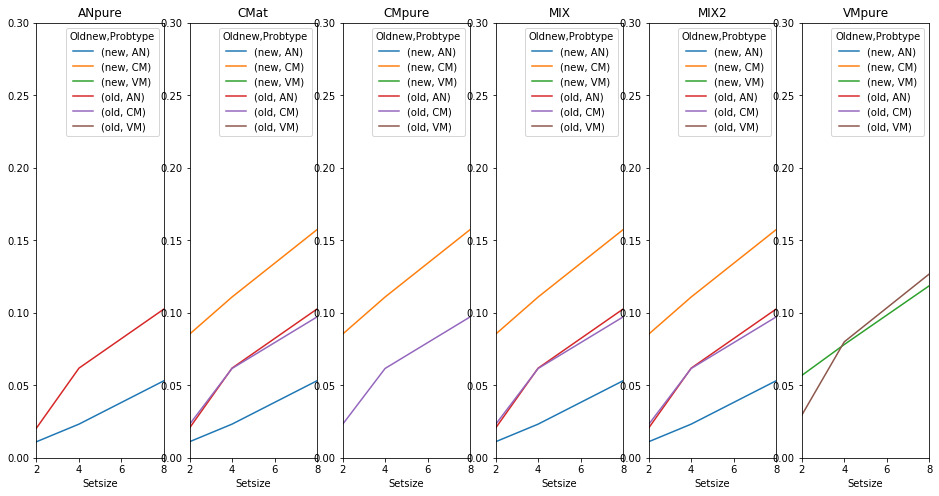

In [266]:

# print(L["CM_oldinew_newiold"])
df_all_crt, df_all_err = finalRW(df_org)

def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


# df_all_aggnew.columns = df_all_aggnew[df_all_aggnew["FileCondi"]==iname].columns.droplevel([1,2])
df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew


all_plot(df_all_aggnew, "pred_error",(0,0.3))

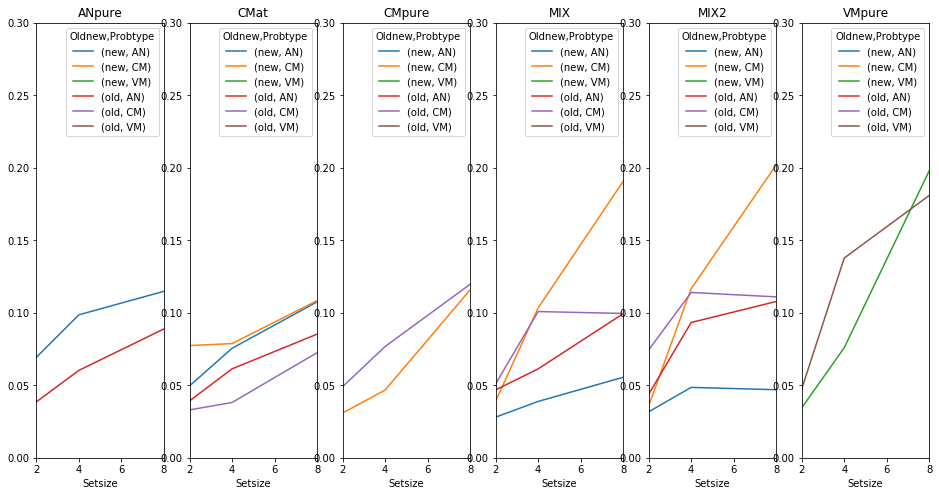

In [97]:
all_plot(df_all_aggnew, "Error",(0,0.3))

## correct RT plot

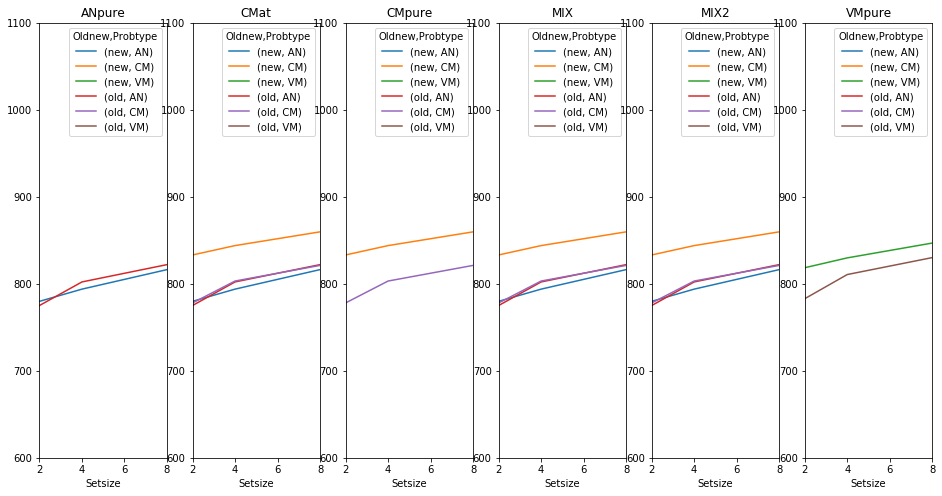

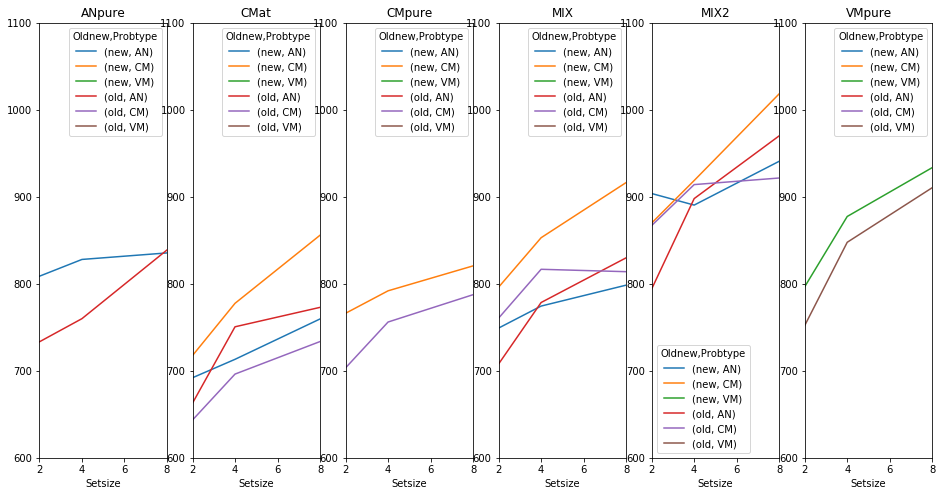

In [256]:
def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_crt.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew


all_plot(df_all_aggnew, "pred_rt",(600,1100))
all_plot(df_all_aggnew, "RT",(600,1100))
